Martin Mendoza\
Youtube API Analysis - Personal Project\
09/23/25

### Project

This project analyzes YouTube channel and video data using the YouTube Data API to find insights on video performance, engagement, and publishing patterns. The goal is to extract, process and visualize important metrics across different YouTube channels to find some trends and explore audience interactions.

Some key features:

Channel and Video Data Extraction:\
    Extracting channel statistics like subscribers, total views, and total videos.\
    Extracting video metadata such as the title, description, tags, published date, duration etc.\
    Gathering top comments for videos.

Data Cleaning and Processing:\
    Converting appropriate columns to numeric for analysis.\
    Calculating additional features:\
        Video duration in seconds\
        Number of tags per video\
        Day of the week when videos were published

Exploratory Data Analysis:\
    Performance analysis: Best and Worst performing videos.\
    Distribution Visualization: violin plots to see view distribution of a channel.\
    Engagement analysis: Scatter plots comparing views vs likes and views vs comments.\
    Duration analysis: Histograms of video durations.\
    Text analysis: Word cloud generated from video titles after removing stop words.

Visualization Tools:\
    Seaborn and Matplotlib for plots and charts.\
    WordCloud for visualizing frequently used words in video titles.\
    Clear formatting for axes, labels, grids and themes.

Purpose and Impact:\
This analysis provides actionable insights for content creators and analysts to understand which videos and channels perform the best and finds trends in engagement. It also personally servers as a hands-on project to practice working with APIs, data clenaing, feature engineering and data visualization in Python.


In [1]:
# Imports
from googleapiclient.discovery import build
import pandas as pd
import requests
import isodate
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
cwd = os.getcwd()

# My API key
key_path = os.path.join(cwd, "api_key.txt")
with open(key_path, "r") as f:
    api_key = f.read().strip()

In [3]:
# Channels to obtain channel_id from
channel_handles = [
    "@JoshuaWeissman", 
    "@bonappetit", 
    "@OptimumTech", 
    "@MKBHD", 
    "@kurzgesagt", 
    "@TheCodingSloth"
]

# Extracting channel ids and printing
for handle in channel_handles:
    response = requests.get(
        "https://www.googleapis.com/youtube/v3/search",
        params={
            "part": "snippet",
            "q": handle,
            "type": "channel",
            "key": api_key
        }
    )

    response_json = response.json()
    
    if "items" in response_json and len(response_json["items"]) > 0:
        channel_id = response_json["items"][0]["snippet"]["channelId"]
        print(handle, ":", channel_id)
    else:
        print(handle, "→ No channel found")

@JoshuaWeissman : UChBEbMKI1eCcejTtmI32UEw
@bonappetit : UCbpMy0Fg74eXXkvxJrtEn3w
@OptimumTech : UCRYOj4DmyxhBVrdvbsUwmAA
@MKBHD : UCBJycsmduvYEL83R_U4JriQ
@kurzgesagt : UCsXVk37bltHxD1rDPwtNM8Q
@TheCodingSloth : UCxVPH8W2ayMey1-b0SY8rBQ


In [4]:
# Channel ids
channel_ids = [
    'UChBEbMKI1eCcejTtmI32UEw', # Joshua Weissman
    'UCbpMy0Fg74eXXkvxJrtEn3w', # Bon Appétit
    'UCRYOj4DmyxhBVrdvbsUwmAA', # Optimum Tech
    'UCBJycsmduvYEL83R_U4JriQ', # MKBHD
    'UCsXVk37bltHxD1rDPwtNM8Q', # kurzgesagt
    'UCxVPH8W2ayMey1-b0SY8rBQ', # The Coding Sloth
    # More channels here
]

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [6]:
# Extracting channel stats
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
        
        
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # Loop though items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']}
        
        all_data.append(data)

    return(pd.DataFrame(all_data))

In [7]:
# Making a channel stats dataframe to show information for each channel
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Joshua Weissman,10300000,2205096436,765,UUhBEbMKI1eCcejTtmI32UEw
1,The Coding Sloth,537000,21253617,47,UUxVPH8W2ayMey1-b0SY8rBQ
2,Bon Appétit,7080000,2050270186,1721,UUbpMy0Fg74eXXkvxJrtEn3w
3,Kurzgesagt – In a Nutshell,24500000,3437309028,308,UUsXVk37bltHxD1rDPwtNM8Q
4,Marques Brownlee,20400000,4986560792,1764,UUBJycsmduvYEL83R_U4JriQ
5,optimum,1390000,313294567,699,UURYOj4DmyxhBVrdvbsUwmAA


In [8]:
# Choosing playlist with channel id
playlist_id = "UURYOj4DmyxhBVrdvbsUwmAA" # optimum

# Extracting videos
def get_video_ids(youtube, playlist_id):
    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    
    # Continue past max results
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
    
    return video_ids


In [9]:
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

694

In [10]:
# Extracting video details
def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        response

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                            'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                            'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']
            
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k] [v]
                    except:
                        video_info[v] = None
                    
            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [11]:
# Making video dataframe to show video details from channel
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,hTnggqnC3ug,optimum,I built a 2000W+ PC. It crushes everything.,Check prices on Amazon below\nPhanteks Evolv S...,"[overkill pc build, dual 5090 pc, RTX 5090, RT...",2025-09-20T12:01:24Z,836092,39485,None,2198,PT11M54S,hd,false
1,z772xJRUeYc,optimum,This has to be aimbot.. right?,Battlefield 6 isn't even out yet and people ar...,"[aimbot, aimbot in battlefield 6, rileycs, tar...",2025-08-14T13:40:55Z,438624,40650,None,11750,PT8M35S,hd,false
2,oMUEsz71_xQ,optimum,My dream gaming mouse is 100% complete,We have reached the summit.\n\nhttps://zeromou...,"[zeromouse, best gaming mouse, 3D printed gami...",2025-07-05T13:27:14Z,524803,29965,None,2700,PT11M53S,hd,false
3,Q-G6A0rJSeE,optimum,I tried the ultimate budget 3D printer,How good can a $250 3D printer possibly be? \n...,"[bambulab a1 mini, best 3D printer, budget 3D ...",2025-06-26T13:26:31Z,387646,13884,None,623,PT10M39S,hd,false
4,WcQmfYO7ies,optimum,"The fastest, brightest OLED.",Check prices on Amazon below\nMSI 500Hz: https...,"[best oled monitor, MSI 272QP X50, brightest o...",2025-06-18T12:47:14Z,551657,18837,None,1325,PT5M55S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,vzSNkrWryQc,optimum,i7 7700k Delidding Results - Is it Worth it?,Delidding is a risky process - but is voiding ...,"[intel, kaby lake, i7, 7700k, CPU, delid, deli...",2017-03-05T03:32:09Z,62562,954,None,177,PT4M50S,hd,false
690,s5yl8_OY0yc,optimum,Battlefield 1 - i5 7600k vs i7 7700k: Do You N...,We're taking a closer look at Battlefield One'...,"[Intel, 7600k, 7700k, battlefield 1, framerate...",2017-02-28T07:09:46Z,52241,316,None,99,PT5M17S,hd,false
691,CnKDxJWIcI8,optimum,Corsair K65 LUX RGB Gaming Keyboard Review - U...,A quick look at one of the best compact gaming...,"[Corsair, k65, lux, rgb, gaming, keyboard, com...",2017-02-22T08:07:20Z,104808,1172,None,97,PT3M,hd,false
692,7gHWeAM7mgc,optimum,BF1 Benchmark - 7700k + GTX1070,"Battlefield 1 Benchmark, 1080p @ Ultra Setting...","[battlefield 1, bf1, benchmark, 7700k, gtx1070...",2017-02-08T09:49:42Z,11561,108,None,21,PT10M46S,hd,false


In [12]:
# Extract comments
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=video_id
        )
        response = request.execute()
        
        comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response.get('items', [])]
        comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
        
        all_comments.append(comments_in_video_info)
        
    return pd.DataFrame(all_comments)

In [13]:
# Making comments dataframe to show video_id and comments
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df

,video_id,comments
0,hTnggqnC3ug,[Solve the SLI heat issue by having a differen...
1,z772xJRUeYc,"[reviewing catgirl gameplay before GTA 6., ima..."
2,oMUEsz71_xQ,"[This sold out a lot faster than expected, I'm..."
3,Q-G6A0rJSeE,[Is this good enough to make a switch…asking f...
4,WcQmfYO7ies,"[Since I moved to OLED, I do not think I can g..."
...,...,...
689,vzSNkrWryQc,"[How long did it last, Although it is a shitty..."
690,s5yl8_OY0yc,[I have done quite a bit of tweaking and my 76...
691,CnKDxJWIcI8,"[damn bro optimums voice back then, oh my god ..."
692,7gHWeAM7mgc,"[optimum can you give me a pc, good ol days, S..."


In [14]:
# Select which video to extract comments from
comments_df['comments'][0]

["Solve the SLI heat issue by having a different case that allows you to mount the GPU vertically when the second GPU is in the Motherboard like normal so the two GPU's are not stacked on each other",
 'Optimum, first you made the mouse, now you need to make a headset. I think you should create the worlds lightest, most beautiful headset. Now you\'re probably like "oh use the fratal scape" but it\'s heavy and the most uncomfortable,punishing to wear headset of all time. The clamp force is unbearable and has no headband cushion. As a guy who\'s had 20+ headsets over the years it\'s like theres something always missing. Now the razer barricuda x is the lightest most comfortable(after buying aftermarket pads), but the mic is terrible, like 20$ gaming headset terrible. So now heres your challenge: Make a wireless, ultra lightweight, 50mm driver, with a class leading super wideband mic. Your quest has now been accepted, now are you up to the challenge?',
 "TIL you're Australian",
 "Turn you

### Data pre-processing

In [15]:
# Check for null values
video_df.isnull().sum()

video_id            0
channelTitle        0
title               0
description         0
tags                9
publishedAt         0
viewCount           0
likeCount           0
favouriteCount    694
commentCount        0
duration            0
definition          0
caption             0
dtype: int64

In [16]:
# Check column datatypes
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [17]:
# Doesnt make sense for all columns to be object
# Convert necessary columns to numerical
numeric_col = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_col] = video_df[numeric_col].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [18]:
# Make a columsn for which day of the week the video is published based on publishedAt column
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'])
video_df['publishedDayName'] = video_df['publishedAt'].dt.day_name()

In [19]:
# Convert youtube video len to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = pd.to_timedelta(video_df['durationSecs']).dt.total_seconds().astype(int)

In [20]:
# Show duration of videos in Seconds
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,714,PT11M54S
1,515,PT8M35S
2,713,PT11M53S
3,639,PT10M39S
4,355,PT5M55S
...,...,...
689,290,PT4M50S
690,317,PT5M17S
691,180,PT3M
692,646,PT10M46S


In [21]:
# Check for number of tags per video
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [22]:
# Check new columsn in dataframe
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs,tagCount
0,hTnggqnC3ug,optimum,I built a 2000W+ PC. It crushes everything.,Check prices on Amazon below\nPhanteks Evolv S...,"[overkill pc build, dual 5090 pc, RTX 5090, RT...",2025-09-20 12:01:24+00:00,836092.0,39485.0,NaN,2198.0,PT11M54S,hd,false,Saturday,714,8
1,z772xJRUeYc,optimum,This has to be aimbot.. right?,Battlefield 6 isn't even out yet and people ar...,"[aimbot, aimbot in battlefield 6, rileycs, tar...",2025-08-14 13:40:55+00:00,438624.0,40650.0,NaN,11750.0,PT8M35S,hd,false,Thursday,515,10
2,oMUEsz71_xQ,optimum,My dream gaming mouse is 100% complete,We have reached the summit.\n\nhttps://zeromou...,"[zeromouse, best gaming mouse, 3D printed gami...",2025-07-05 13:27:14+00:00,524803.0,29965.0,NaN,2700.0,PT11M53S,hd,false,Saturday,713,6
3,Q-G6A0rJSeE,optimum,I tried the ultimate budget 3D printer,How good can a $250 3D printer possibly be? \n...,"[bambulab a1 mini, best 3D printer, budget 3D ...",2025-06-26 13:26:31+00:00,387646.0,13884.0,NaN,623.0,PT10M39S,hd,false,Thursday,639,8
4,WcQmfYO7ies,optimum,"The fastest, brightest OLED.",Check prices on Amazon below\nMSI 500Hz: https...,"[best oled monitor, MSI 272QP X50, brightest o...",2025-06-18 12:47:14+00:00,551657.0,18837.0,NaN,1325.0,PT5M55S,hd,false,Wednesday,355,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,vzSNkrWryQc,optimum,i7 7700k Delidding Results - Is it Worth it?,Delidding is a risky process - but is voiding ...,"[intel, kaby lake, i7, 7700k, CPU, delid, deli...",2017-03-05 03:32:09+00:00,62562.0,954.0,NaN,177.0,PT4M50S,hd,false,Sunday,290,16
690,s5yl8_OY0yc,optimum,Battlefield 1 - i5 7600k vs i7 7700k: Do You N...,We're taking a closer look at Battlefield One'...,"[Intel, 7600k, 7700k, battlefield 1, framerate...",2017-02-28 07:09:46+00:00,52241.0,316.0,NaN,99.0,PT5M17S,hd,false,Tuesday,317,14
691,CnKDxJWIcI8,optimum,Corsair K65 LUX RGB Gaming Keyboard Review - U...,A quick look at one of the best compact gaming...,"[Corsair, k65, lux, rgb, gaming, keyboard, com...",2017-02-22 08:07:20+00:00,104808.0,1172.0,NaN,97.0,PT3M,hd,false,Wednesday,180,8
692,7gHWeAM7mgc,optimum,BF1 Benchmark - 7700k + GTX1070,"Battlefield 1 Benchmark, 1080p @ Ultra Setting...","[battlefield 1, bf1, benchmark, 7700k, gtx1070...",2017-02-08 09:49:42+00:00,11561.0,108.0,NaN,21.0,PT10M46S,hd,false,Wednesday,646,6


## EDA

### Best and worst performing videos

In [23]:
# Format y-axis labels
def format_view_count(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{int(x)}'

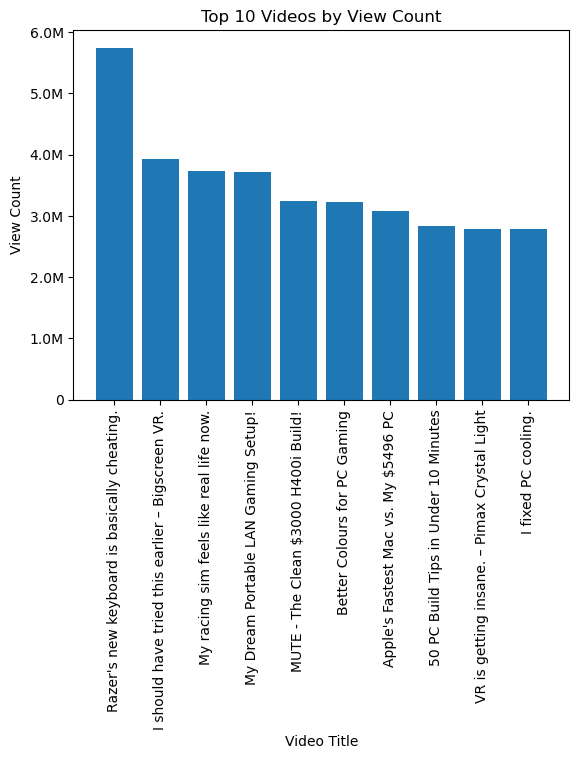

In [24]:
# Barchart of top 10 videos by view count
top_videos = video_df.sort_values('viewCount', ascending=False).head(10)
ax = plt.bar(top_videos['title'], top_videos['viewCount'])
plt.xticks(rotation=90)
ax = plt.gca()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_view_count))
plt.xlabel("Video Title")
plt.ylabel("View Count")
plt.title("Top 10 Videos by View Count")
plt.show()

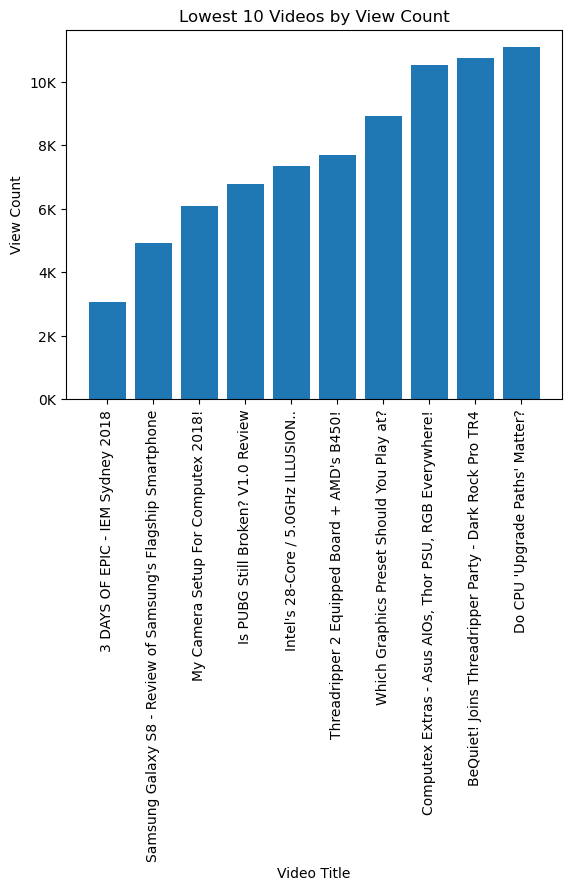

In [25]:
# Barchart of lowest 10 videos by view count
top_videos = video_df.sort_values('viewCount', ascending=True).head(10)
plt.bar(top_videos['title'], top_videos['viewCount'])
plt.xticks(rotation=90)

# Format y-axis in thousands
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}K'.format(x/1000))
)

plt.xlabel("Video Title")
plt.ylabel("View Count")
plt.title("Lowest 10 Videos by View Count")
plt.show()

### View distribution per video

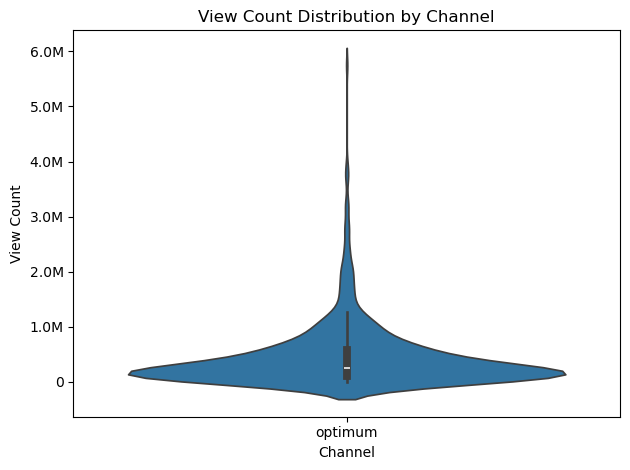

In [26]:
# Violin plot and assign the axes
ax = sns.violinplot(x='channelTitle', y='viewCount', data=video_df)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_view_count))
plt.title("View Count Distribution by Channel")
plt.xlabel("Channel")
plt.ylabel("View Count")
plt.tight_layout()
plt.show()

### Views vs. likes and comments

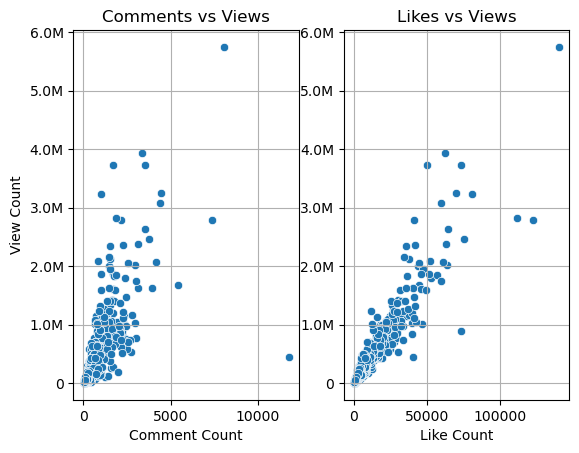

In [27]:
fig, ax = plt.subplots(1,2)
# Scatter: comments vs views
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_view_count))
ax[0].set_title("Comments vs Views")
ax[0].set_xlabel("Comment Count")
ax[0].set_ylabel("View Count")
ax[0].grid(True)

# Scatter: likes vs views
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(format_view_count))
ax[1].set_title("Likes vs Views")
ax[1].set_xlabel("Like Count")
ax[1].set_ylabel("")
ax[1].grid(True)

### Video duration

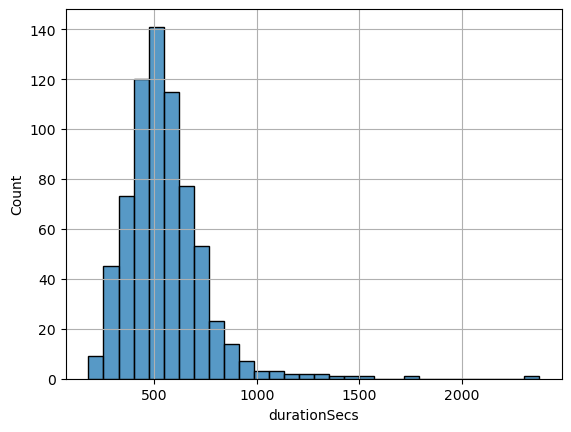

In [28]:
# Histogram of video durations (in seconds)
sns.histplot(data = video_df, x = 'durationSecs', bins=30)
plt.grid(True)

### Wordcloud for video titles

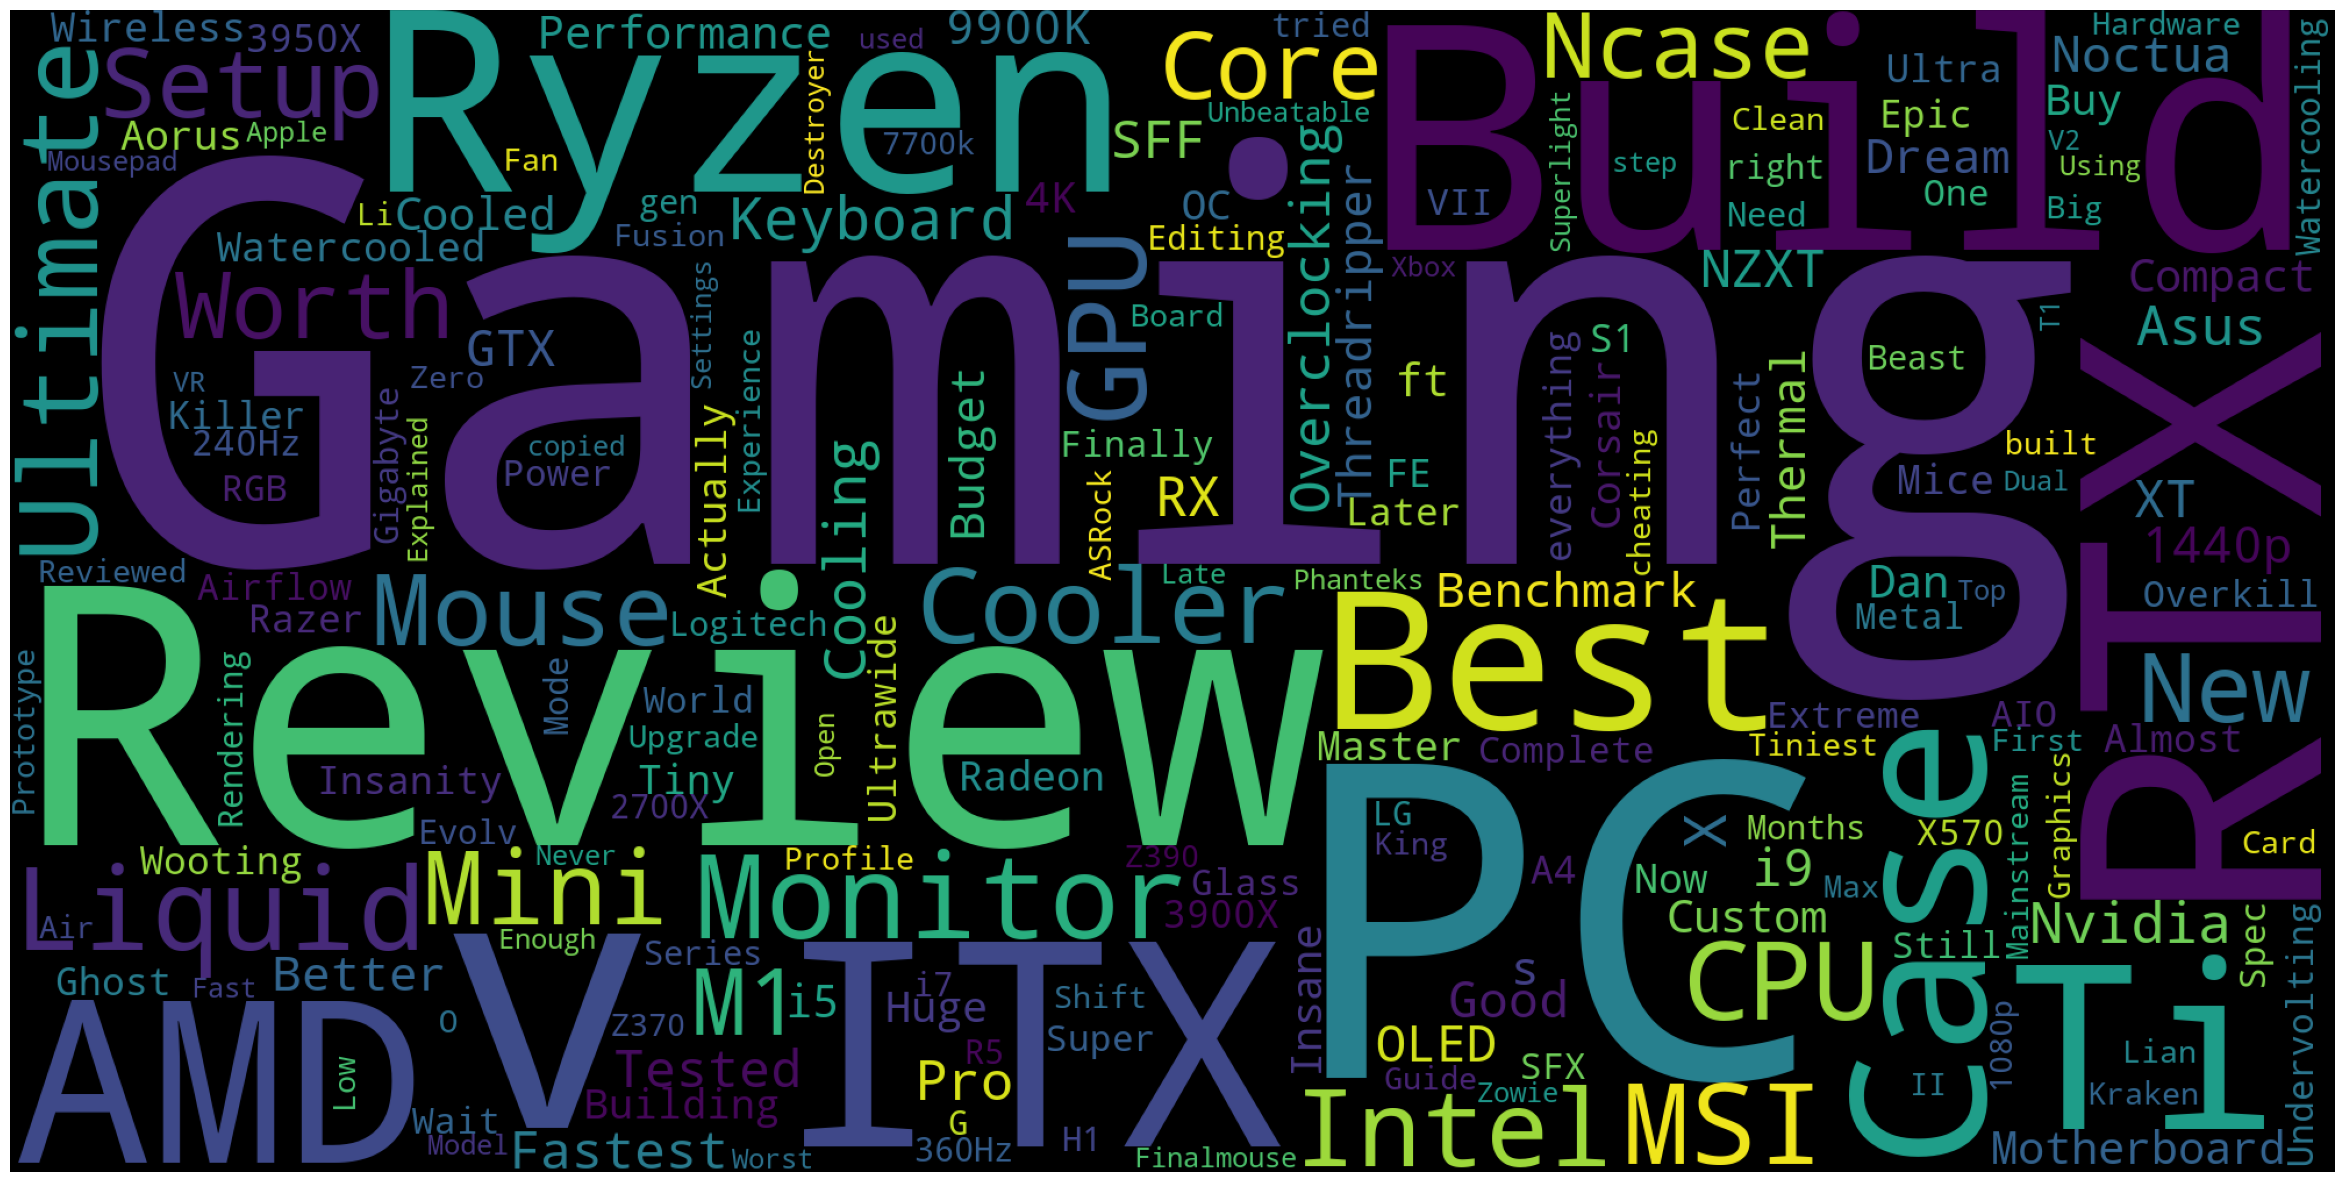

In [29]:
# Word cloud from video titles
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")

wordcloud = WordCloud( width=2000, height=1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)

plot_cloud(wordcloud)


### Upload Schedual

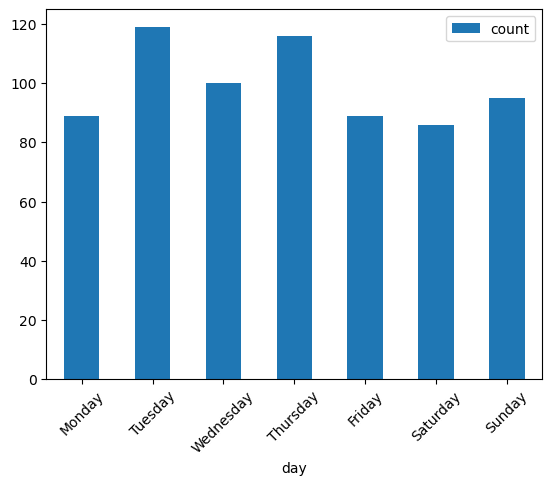

In [30]:
# Number of videos published on each weekday
day_df = video_df['publishedDayName'].value_counts().rename_axis('day').reset_index(name='count')
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.set_index('day').reindex(weekdays).reset_index()
ax = day_df.plot.bar(x='day', y='count', rot=45)